In [2]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

/Users/khair1212/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data = pd.read_csv('transaction_data_with_seasonality_100k.csv', parse_dates=['transaction_date']) 

In [4]:
item_id = 1 

In [5]:
data.set_index('transaction_date', inplace=True)

In [6]:
daily_data = data.groupby(['item_id']).resample('D').agg({
    'quantity': 'sum',
    'price': 'mean'
}).reset_index().fillna(method='ffill')

In [7]:
daily_data

,item_id,transaction_date,quantity,price
0,1,2019-01-01,37,28.163286
1,1,2019-01-02,22,31.694365
2,1,2019-01-03,8,12.728952
3,1,2019-01-04,11,37.025888
4,1,2019-01-05,9,11.726826
...,...,...,...,...
40475,20,2024-07-12,5,59.483621
40476,20,2024-07-13,4,18.324955
40477,20,2024-07-14,8,17.548677
40478,20,2024-07-15,1,58.698119


In [8]:
item_data = daily_data[(daily_data['item_id'] == item_id)] 
item_data.set_index('transaction_date', inplace=True) 


<Axes: xlabel='transaction_date'>

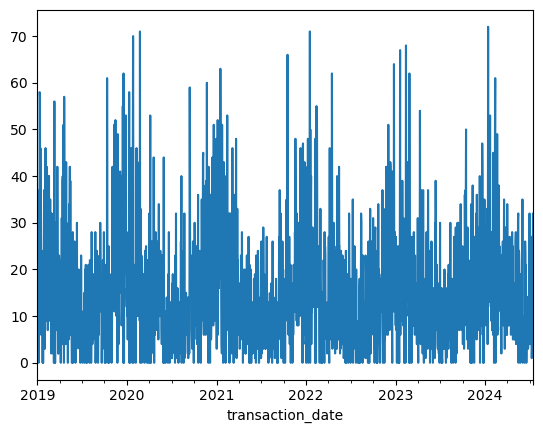

In [9]:
item_data['quantity'].plot()

In [10]:
# Split the data into train and test sets
train_size = int(len(item_data) * 0.8) 
train_data, test_data = item_data[:train_size], item_data[train_size:] 


In [11]:
model = SARIMAX(train_data['quantity'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))  # Annual seasonality
model_fit = model.fit(disp=False) 


/Users/khair1212/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/khair1212/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [11]:
# Forecast 
forecast = model_fit.forecast(steps=len(test_data)) 


# Evaluate the model 
r2 = r2_score(test_data['quantity'], forecast) 
mse = mean_squared_error(test_data['quantity'], forecast) 
rmse = np.sqrt(mse) 
print(f'RMSE (Daily): {rmse} \n R2 (Daily): {r2}') 

RMSE (Daily): 12.741120682414934


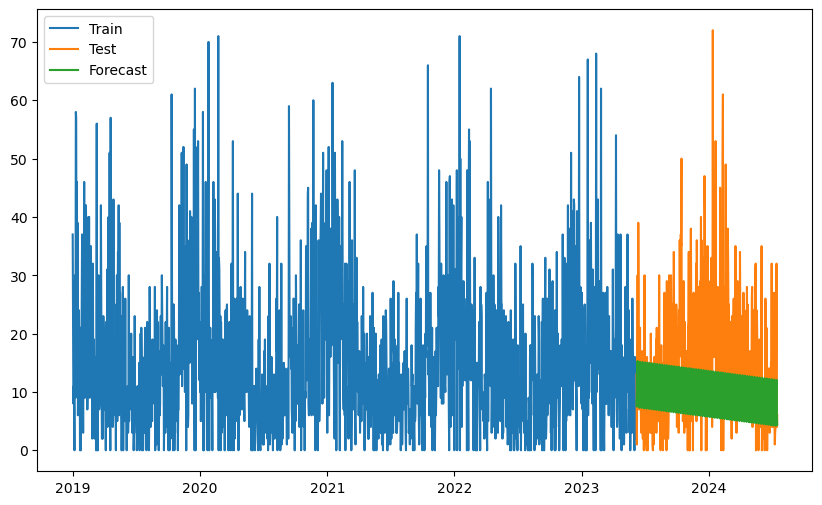

In [12]:

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['quantity'], label='Train')
plt.plot(test_data.index, test_data['quantity'], label='Test')
plt.plot(test_data.index, forecast, label='Forecast')
plt.legend()
plt.show()

## Data Preprocessing

In [12]:
daily_data.head()

,item_id,transaction_date,quantity,price
0,1,2019-01-01,37,28.163286
1,1,2019-01-02,22,31.694365
2,1,2019-01-03,8,12.728952
3,1,2019-01-04,11,37.025888
4,1,2019-01-05,9,11.726826


In [24]:
p_daily_data = daily_data.copy()

In [71]:

# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# p_daily_data[['quantity', 'price']] = scaler.fit_transform(p_daily_data[['quantity', 'price']])


In [25]:
p_daily_data['day_of_week'] = p_daily_data['transaction_date'].dt.dayofweek
p_daily_data['month'] = p_daily_data['transaction_date'].dt.month


In [26]:
p_daily_data.head()

,item_id,transaction_date,quantity,price,day_of_week,month
0,1,2019-01-01,37,28.163286,1,1
1,1,2019-01-02,22,31.694365,2,1
2,1,2019-01-03,8,12.728952,3,1
3,1,2019-01-04,11,37.025888,4,1
4,1,2019-01-05,9,11.726826,5,1


In [27]:
# Add lag features
p_daily_data['lag_1'] = p_daily_data['quantity'].shift(1)
p_daily_data['lag_7'] = p_daily_data['quantity'].shift(7)
# p_daily_data['lag_30'] = p_daily_data['quantity'].shift(30)


In [28]:
# Add rolling statistics
p_daily_data['rolling_mean_3'] = p_daily_data['quantity'].rolling(window=3).mean()
p_daily_data['rolling_std_3'] = p_daily_data['quantity'].rolling(window=3).std()
p_daily_data['rolling_mean_7'] = p_daily_data['quantity'].rolling(window=7).mean()
p_daily_data['rolling_std_7'] = p_daily_data['quantity'].rolling(window=7).std()


In [29]:
# Ensure no missing values in new features
p_daily_data.dropna(inplace=True)

In [30]:

p_item_data = p_daily_data[(p_daily_data['item_id'] == item_id)]
p_item_data.set_index('transaction_date', inplace=True)


In [31]:
# Split the data into train and test sets
train_size = int(len(p_item_data) * 0.8)
train_data, test_data = p_item_data[:train_size], p_item_data[train_size:]


In [32]:
p_item_data

,item_id,quantity,price,day_of_week,month,lag_1,lag_7,rolling_mean_3,rolling_std_3,rolling_mean_7,rolling_std_7
transaction_date,,,,,,,,,,,
2019-01-08,1,30,27.971905,1,1,28.0,37.0,19.333333,16.772994,15.428571,11.311604
2019-01-09,1,9,18.982530,2,1,30.0,22.0,22.333333,11.590226,13.571429,11.118410
2019-01-10,1,58,22.732408,3,1,9.0,8.0,32.333333,24.583192,20.714286,19.695298
2019-01-11,1,57,24.001775,4,1,58.0,11.0,41.333333,28.005952,27.285714,23.264524
2019-01-12,1,26,35.865545,5,1,57.0,9.0,47.000000,18.193405,29.714286,21.883893
...,...,...,...,...,...,...,...,...,...,...,...
2024-07-12,1,5,32.114854,4,7,4.0,4.0,4.000000,1.000000,7.857143,8.877473
2024-07-13,1,19,12.436805,5,7,5.0,10.0,9.333333,8.386497,9.142857,9.839183
2024-07-14,1,32,45.002414,6,7,19.0,27.0,18.666667,13.503086,9.857143,11.408017


In [33]:
# Define the exogenous features
exog_features = ['price', 'day_of_week', 'month', 'lag_1', 'lag_7', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_3', 'rolling_std_3']


In [34]:
# Train the model
model = SARIMAX(train_data['quantity'], 
                order=(1, 1, 1), 
                seasonal_order=(1, 1, 1, 7),  # Weekly seasonality
                exog=train_data[exog_features])
model_fit = model.fit(disp=False)

/Users/khair1212/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/khair1212/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/khair1212/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [35]:
# Forecast
train_forecast = model_fit.forecast(steps=len(train_data), exog=train_data[exog_features])
test_forecast = model_fit.forecast(steps=len(test_data), exog=test_data[exog_features])

In [37]:

# Evaluate the model 
r2 = r2_score(test_data['quantity'], test_forecast) 
mse = mean_squared_error(test_data['quantity'], test_forecast) 
rmse = np.sqrt(mse) 
print(f'RMSE (Daily): {rmse} \n R2 (Daily): {r2}') 

RMSE (Daily): 69.88567720664201 
 R2 (Daily): -37.944241089235014


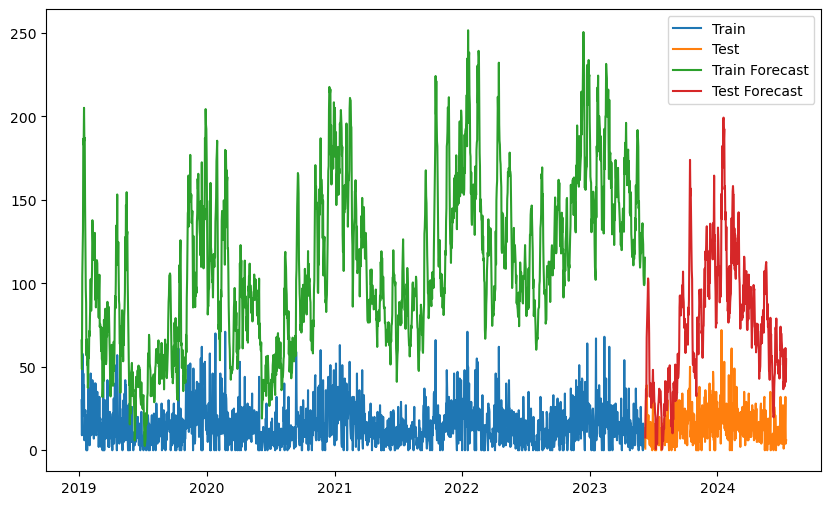

In [38]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['quantity'], label='Train')
plt.plot(test_data.index, test_data['quantity'], label='Test')
plt.plot(train_data.index, train_forecast, label='Train Forecast')
plt.plot(test_data.index, test_forecast, label='Test Forecast')
plt.legend()
plt.show()

# Prophet

In [39]:
item_data.head()

,item_id,quantity,price
transaction_date,,,
2019-01-01,1,37,28.163286
2019-01-02,1,22,31.694365
2019-01-03,1,8,12.728952
2019-01-04,1,11,37.025888
2019-01-05,1,9,11.726826


In [40]:
item_data_prophet = item_data.reset_index()[['transaction_date', 'quantity']].rename(columns={'transaction_date': 'ds', 'quantity': 'y'})


In [41]:
train_size = int(len(item_data_prophet) * 0.8)
train_data, test_data = item_data_prophet[:train_size], item_data_prophet[train_size:]


In [42]:
model = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=True)
model.fit(train_data)

05:26:47 - cmdstanpy - INFO - Chain [1] start processing
05:26:47 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
# Make future dataframe and forecast
future = model.make_future_dataframe(periods=len(test_data), freq='D')
forecast = model.predict(future)

In [47]:

# Evaluate the model
mse = mean_squared_error(test_data['y'], forecast['yhat'][len(train_data):])
r2 = r2_score(test_data['y'], forecast['yhat'][len(train_data):])
rmse = np.sqrt(mse)
print(f'Prophet RMSE: {rmse} \n R2: {r2}')

Prophet RMSE: 9.947964829958433 
 R2: 0.20901955910452552


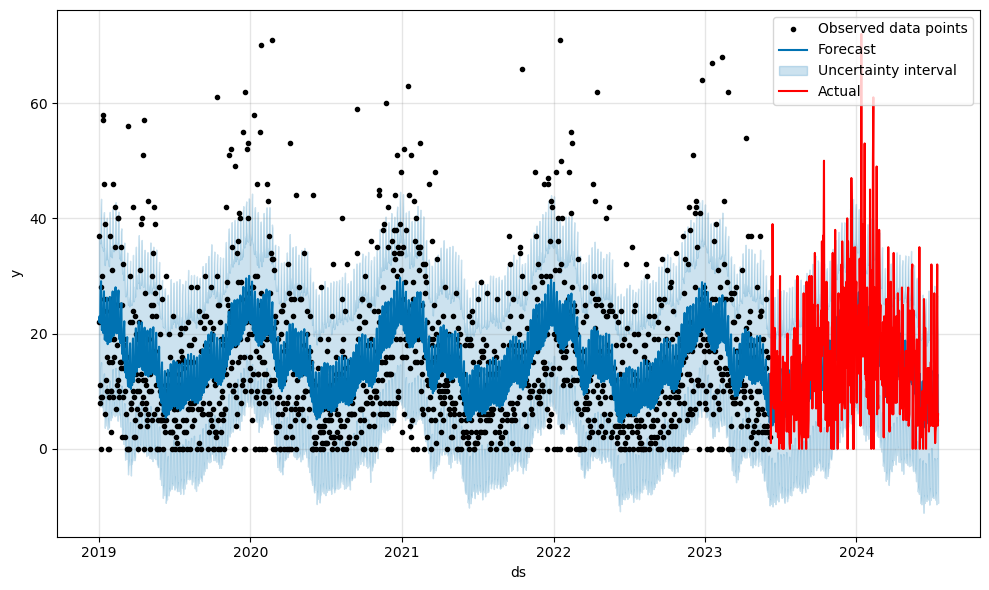

In [44]:
# Plot the forecast
fig = model.plot(forecast)
plt.plot(test_data['ds'], test_data['y'], 'r', label='Actual')
plt.legend()
plt.show()

In [45]:
pd.DataFrame({"date":test_data['ds'], "test":test_data['y'], "forecast":forecast['yhat']}).dropna()

,date,test,forecast
1619,2023-06-08,13.0,5.306393
1620,2023-06-09,1.0,4.419407
1621,2023-06-10,16.0,10.305546
1622,2023-06-11,30.0,12.019801
1623,2023-06-12,14.0,5.599215
...,...,...,...
2019,2024-07-12,5.0,5.297630
2020,2024-07-13,19.0,11.213638
2021,2024-07-14,32.0,12.934445
2022,2024-07-15,4.0,6.500414


# Preprocessing and Feature Engineering

In [100]:
p_item_data_prophet = p_item_data[['quantity']].reset_index().rename(columns={'transaction_date': 'ds', 'quantity': 'y'})


In [101]:
p_item_data

,item_id,quantity,price,day_of_week,month,lag_1,lag_7,rolling_mean_3,rolling_std_3,rolling_mean_7,rolling_std_7
transaction_date,,,,,,,,,,,
2019-01-08,1,30,27.971905,1,1,28.0,37.0,19.333333,16.772994,15.428571,11.311604
2019-01-09,1,9,18.982530,2,1,30.0,22.0,22.333333,11.590226,13.571429,11.118410
2019-01-10,1,58,22.732408,3,1,9.0,8.0,32.333333,24.583192,20.714286,19.695298
2019-01-11,1,57,24.001775,4,1,58.0,11.0,41.333333,28.005952,27.285714,23.264524
2019-01-12,1,26,35.865545,5,1,57.0,9.0,47.000000,18.193405,29.714286,21.883893
...,...,...,...,...,...,...,...,...,...,...,...
2024-07-12,1,5,32.114854,4,7,4.0,4.0,4.000000,1.000000,7.857143,8.877473
2024-07-13,1,19,12.436805,5,7,5.0,10.0,9.333333,8.386497,9.142857,9.839183
2024-07-14,1,32,45.002414,6,7,19.0,27.0,18.666667,13.503086,9.857143,11.408017


In [102]:
# Adding additional regressors
p_item_data_prophet['price'] = p_item_data['price'].values
p_item_data_prophet['day_of_week'] = p_item_data['day_of_week'].values
p_item_data_prophet['month'] = p_item_data['month'].values
p_item_data_prophet['lag_1'] = p_item_data['lag_1'].values
p_item_data_prophet['lag_7'] = p_item_data['lag_7'].values
p_item_data_prophet['rolling_mean_3'] = p_item_data['rolling_mean_3'].values
p_item_data_prophet['rolling_std_3'] = p_item_data['rolling_std_3'].values 
p_item_data_prophet['rolling_mean_7'] = p_item_data['rolling_mean_7'].values
p_item_data_prophet['rolling_std_7'] = p_item_data['rolling_std_7'].values

In [103]:
train_size = int(len(p_item_data_prophet) * 0.8)
train_data, test_data = p_item_data_prophet[:train_size], p_item_data_prophet[train_size:]


In [104]:
# Define and fit the model
model = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
model.add_regressor('price')
model.add_regressor('day_of_week')
model.add_regressor('month')
model.add_regressor('lag_1')
model.add_regressor('lag_7')
model.add_regressor('rolling_std_3')
model.add_regressor('rolling_mean_3')
model.add_regressor('rolling_mean_7')
model.add_regressor('rolling_std_7')

model.fit(train_data)

06:01:50 - cmdstanpy - INFO - Chain [1] start processing
06:01:50 - cmdstanpy - INFO - Chain [1] done processing


In [105]:
# Make future dataframe and forecast
future = model.make_future_dataframe(periods=len(test_data), freq='D')

print(future.shape, test_data.shape)

(2017, 1) (404, 11)


In [106]:
future = future.loc[len(train_data):]

In [107]:
future['price'] = test_data['price'].values
future['day_of_week'] = test_data['day_of_week'].values
future['month'] = test_data['month'].values
future['lag_1'] = test_data['lag_1'].values
future['lag_7'] = test_data['lag_7'].values 

future['rolling_mean_3'] = test_data.rolling_mean_3.values
future['rolling_std_3'] = test_data.rolling_std_3.values

future['rolling_mean_7'] = test_data.rolling_mean_7.values
future['rolling_std_7'] = test_data.rolling_std_7.values

forecast = model.predict(future)

In [108]:


# Evaluate the model
mse = mean_squared_error(test_data['y'], forecast['yhat'])
r2 = r2_score(test_data['y'], forecast['yhat'])
rmse = np.sqrt(mse)
print(f'Prophet RMSE: {rmse} \n R2: {r2}')

Prophet RMSE: 6.6734683656773655 
 R2: 0.6448841134062084


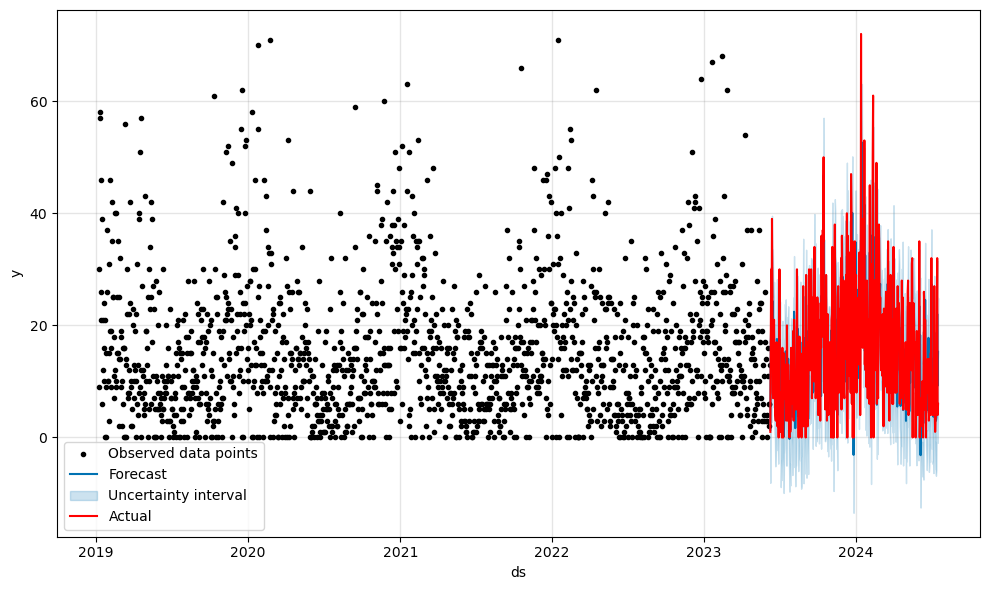

In [109]:
# Plot the forecast
fig = model.plot(forecast) 
plt.plot(test_data['ds'], test_data['y'], 'r', label='Actual') 
plt.legend() 
plt.show() 

In [110]:
plt_data = pd.DataFrame({"ds":test_data['ds'], "actual":test_data['y']}) 

In [111]:
plt_data = pd.merge(plt_data, forecast, on='ds')[['ds', 'actual', 'yhat']]

In [112]:
plt_data

,ds,actual,yhat
0,2023-06-09,1,1.332503
1,2023-06-10,16,17.067331
2,2023-06-11,30,19.388654
3,2023-06-12,14,12.731987
4,2023-06-13,39,30.377698
...,...,...,...
399,2024-07-12,5,3.601126
400,2024-07-13,19,13.828390
401,2024-07-14,32,22.037074
402,2024-07-15,4,9.238627


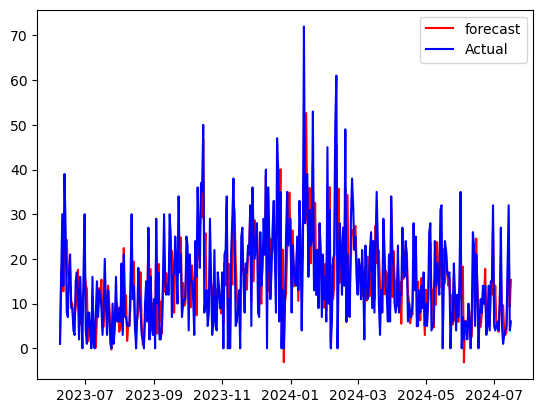

In [76]:
# Plot the forecast
# plt.plot(train_data['date'], train_data['quantity'], color = 'blue')
plt.plot(plt_data['ds'], plt_data['yhat'], color = 'red', label = 'forecast')
plt.plot(plt_data['ds'], plt_data['actual'], 'blue', label='Actual')
plt.legend()
plt.show()

# XGBoost 

In [78]:
rf_data = p_item_data.reset_index()

In [79]:
rf_data.head()

,transaction_date,item_id,quantity,price,day_of_week,month,lag_1,lag_7,rolling_mean_3,rolling_std_3,rolling_mean_7,rolling_std_7
0,2019-01-08,1,30,27.971905,1,1,28.0,37.0,19.333333,16.772994,15.428571,11.311604
1,2019-01-09,1,9,18.982530,2,1,30.0,22.0,22.333333,11.590226,13.571429,11.118410
2,2019-01-10,1,58,22.732408,3,1,9.0,8.0,32.333333,24.583192,20.714286,19.695298
3,2019-01-11,1,57,24.001775,4,1,58.0,11.0,41.333333,28.005952,27.285714,23.264524
4,2019-01-12,1,26,35.865545,5,1,57.0,9.0,47.000000,18.193405,29.714286,21.883893


In [80]:
train_size = int(len(rf_data) * 0.8)
train_data, test_data = rf_data[:train_size], rf_data[train_size:]


In [81]:
X_train = train_data.drop(['quantity', 'item_id', 'transaction_date'], axis = 1)
y_train = train_data['quantity']

X_test = test_data.drop(['quantity', 'item_id', 'transaction_date'], axis=1)
y_test = test_data['quantity']



In [82]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [83]:
forecast = xgb.predict(X_test)

In [84]:
# Evaluate the model
mse = mean_squared_error(y_test, forecast)
r2 = r2_score(y_test, forecast)
rmse = np.sqrt(mse)
print(f'XGBoost RMSE: {rmse} \n R2: {r2}')

XGBoost RMSE: 8.347214382139263 
 R2: 0.4444156289100647


In [85]:
plt_data  = pd.DataFrame({'date': test_data['transaction_date'], 'forecast': forecast, 'actual': y_test})

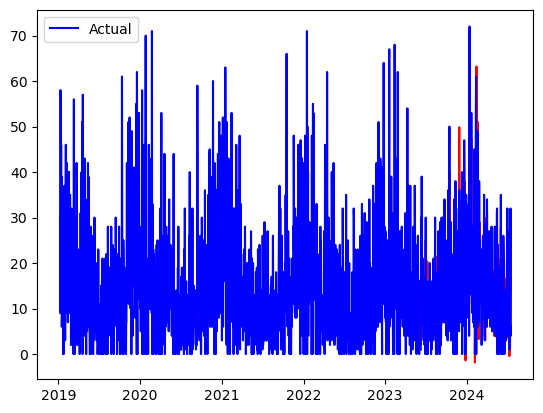

In [86]:
# Plot the forecast
plt.plot(train_data['transaction_date'], train_data['quantity'], color = 'blue')
plt.plot(plt_data['date'], plt_data['forecast'], color = 'red')
plt.plot(plt_data['date'], plt_data['actual'], 'blue', label='Actual')
plt.legend()
plt.show()

# Random Forest

In [87]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [88]:
forecast = rf.predict(X_test)

In [89]:
# Evaluate the model
mse = mean_squared_error(y_test, forecast)
r2 = r2_score(y_test, forecast)
rmse = np.sqrt(mse)
print(f'Random Forest RMSE: {rmse} \n R2: {r2}')

Random Forest RMSE: 8.121768405323005 
 R2: 0.47402137933416555


In [90]:
plt_data  = pd.DataFrame({'date': test_data['transaction_date'], 'forecast': forecast, 'actual': y_test})

In [92]:
plt_data.head()

,date,forecast,actual
1613,2023-06-09,3.59,1
1614,2023-06-10,9.54,16
1615,2023-06-11,22.47,30
1616,2023-06-12,15.45,14
1617,2023-06-13,32.69,39


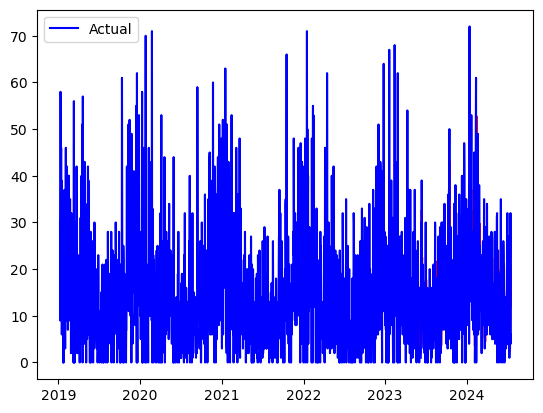

In [91]:
# Plot the forecast
plt.plot(train_data['transaction_date'], train_data['quantity'], color = 'blue')
plt.plot(plt_data['date'], plt_data['forecast'], color = 'red')
plt.plot(plt_data['date'], plt_data['actual'], 'blue', label='Actual')
plt.legend()
plt.show()

# CatBoost

In [93]:
cb = CatBoostRegressor()
cb.fit(X_train, y_train)

Learning rate set to 0.044156
0:	learn: 12.1786309	total: 56.7ms	remaining: 56.6s
1:	learn: 11.9661929	total: 57.5ms	remaining: 28.7s
2:	learn: 11.7844669	total: 58.3ms	remaining: 19.4s
3:	learn: 11.5954651	total: 59.1ms	remaining: 14.7s
4:	learn: 11.4060912	total: 59.9ms	remaining: 11.9s
5:	learn: 11.2304568	total: 60.6ms	remaining: 10s
6:	learn: 11.0774170	total: 61.4ms	remaining: 8.72s
7:	learn: 10.9227848	total: 62.2ms	remaining: 7.72s
8:	learn: 10.8050732	total: 63ms	remaining: 6.94s
9:	learn: 10.6971398	total: 63.8ms	remaining: 6.32s
10:	learn: 10.5839424	total: 64.6ms	remaining: 5.81s
11:	learn: 10.4829100	total: 65.4ms	remaining: 5.39s
12:	learn: 10.3843401	total: 66.2ms	remaining: 5.02s
13:	learn: 10.2985017	total: 66.9ms	remaining: 4.71s
14:	learn: 10.2111300	total: 67.7ms	remaining: 4.45s
15:	learn: 10.1024276	total: 68.3ms	remaining: 4.2s
16:	learn: 10.0193692	total: 69ms	remaining: 3.99s
17:	learn: 9.9294673	total: 69.8ms	remaining: 3.81s
18:	learn: 9.8426031	total: 70.6ms

In [94]:
forecast = cb.predict(X_test)

In [95]:
# Evaluate the model
mse = mean_squared_error(y_test, forecast)
r2 = r2_score(y_test, forecast)
rmse = np.sqrt(mse)
print(f'CatBoost RMSE: {rmse} \n R2: {r2}')

CatBoost RMSE: 7.936085116684632 
 R2: 0.4977967447511902


In [99]:
plt_data_cat  = pd.DataFrame({'date': test_data['transaction_date'], 'forecast': forecast, 'actual': y_test})

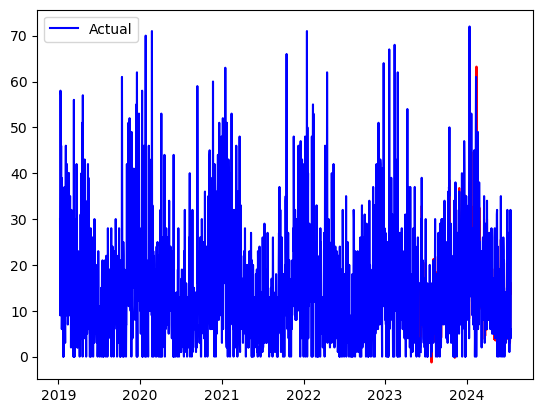

In [97]:
# Plot the forecast
plt.plot(train_data['transaction_date'], train_data['quantity'], color = 'blue')
plt.plot(plt_data_cat['date'], plt_data_cat['forecast'], color = 'red')
plt.plot(plt_data_cat['date'], plt_data_cat['actual'], 'blue', label='Actual')
plt.legend()
plt.show()

In [98]:
plt_data

,date,forecast,actual
1613,2023-06-09,4.446532,1
1614,2023-06-10,13.024736,16
1615,2023-06-11,23.556698,30
1616,2023-06-12,14.519387,14
1617,2023-06-13,32.863368,39
...,...,...,...
2012,2024-07-12,3.146964,5
2013,2024-07-13,7.394911,19
2014,2024-07-14,15.584824,32
2015,2024-07-15,13.671351,4


# Hybrid Approach 

In [124]:
plt_data_cat['prophet+catboost'] = (plt_data['yhat'].values + plt_data_cat['forecast'].values) // 2

In [125]:
plt_data_cat

,date,forecast,actual,prophet+catboost
1613,2023-06-09,4.446532,1,2.0
1614,2023-06-10,13.024736,16,15.0
1615,2023-06-11,23.556698,30,21.0
1616,2023-06-12,14.519387,14,13.0
1617,2023-06-13,32.863368,39,31.0
...,...,...,...,...
2012,2024-07-12,3.146964,5,3.0
2013,2024-07-13,7.394911,19,10.0
2014,2024-07-14,15.584824,32,18.0
2015,2024-07-15,13.671351,4,11.0


In [126]:
# Evaluate the model
mse = mean_squared_error(y_test, plt_data_cat['prophet+catboost'].values)
r2 = r2_score(y_test, plt_data_cat['prophet+catboost'].values)
rmse = np.sqrt(mse)
print(f'Hybrid RMSE: {rmse} \n R2: {r2}')

CatBoost RMSE: 7.048277649311368 
 R2: 0.6038744122015365
